# Scenario 6

Use random forest classifier to predict LogSalePrice. 

Use features selected by Lasso and SequentialFeatureSelector

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
df = pd.read_csv(
    "data/ames_housing_clean_1.csv",
    keep_default_na=False,  
    na_values=["", " "],
    dtype={'MSSubClass': 'str'}
)

In [20]:
# Define the features to use
selected_features = {
    'BldgType', 'BsmtExposure', 'BsmtFinSF1', 'BsmtQual', 'Condition2', 
    'ExterCond', 'ExterQual', 'Exterior1st', 'Functional', 'GarageArea', 
    'GarageCond', 'GrLivArea', 'KitchenQual', 'MSSubClass', 'MSZoning', 
    'MasVnrArea', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofMatl', 
    'SaleCondition', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'
}

df['LogSalePrice'] = np.log(df['SalePrice'])

# Create feature matrix and target variable
X = df[list(selected_features)]
y = df['LogSalePrice']

print(f"\nFeature matrix shape: {X.shape}")


Feature matrix shape: (2576, 24)


In [21]:
# Check for missing values
print(f"\nMissing values in features:")
missing_vals = X.isnull().sum()
print(missing_vals[missing_vals > 0])


Missing values in features:
Series([], dtype: int64)


In [22]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Numeric features (9): ['GarageArea', 'OverallQual', 'BsmtFinSF1', 'GrLivArea', 'TotalBsmtSF', 'YearRemodAdd', 'YearBuilt', 'OverallCond', 'MasVnrArea']
Categorical features (15): ['MSSubClass', 'KitchenQual', 'Functional', 'MSZoning', 'BsmtQual', 'RoofMatl', 'BldgType', 'Exterior1st', 'BsmtExposure', 'GarageCond', 'ExterCond', 'Condition2', 'Neighborhood', 'ExterQual', 'SaleCondition']


In [23]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")



Training set size: 2060
Test set size: 516


In [24]:
# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed feature matrix shape: {X_train_processed.shape}")

Processed feature matrix shape: (2060, 120)


/Users/avrincon/Sync/NYC-DSA/Projects/Ames-Iowa-home-sales/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [5, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': range(1, 31, 5),
    'n_estimators': range(20, 220, 20)
}


In [34]:
print("\n=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===")
# Perform grid search with cross-validation
grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
print("Training models with different hyperparameter combinations...")
grid_search.fit(X_train_processed, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R² score: {grid_search.best_score_:.4f}")


=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===
Training models with different hyperparameter combinations...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best parameters: {'max_depth': 18, 'n_estimators': 100}
Best CV R² score: 0.8829


In [35]:
# Use the best model
rf_model = grid_search.best_estimator_

# Make predictions with the best model
print(f"\nMaking predictions with best model:")
print(f"Best model parameters: {rf_model.get_params()}")
y_train_pred = rf_model.predict(X_train_processed)
y_test_pred = rf_model.predict(X_test_processed)

# Calculate metrics for log scale
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n=== MODEL PERFORMANCE (Log Scale) ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Making predictions with best model:
Best model parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

=== MODEL PERFORMANCE (Log Scale) ===
Training R²: 0.9834
Test R²: 0.9050
Training RMSE: 0.0499
Test RMSE: 0.1187
Training MAE: 0.0330
Test MAE: 0.0875


In [ ]:
# Feature importance analysis
# Get feature names after preprocessing
numeric_feature_names = numeric_features
cat_encoder = preprocessor.named_transformers_['cat']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
all_feature_names = numeric_feature_names + categorical_feature_names

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n=== TOP 20 FEATURE IMPORTANCES ===")
print(feature_importance.head(20))



=== TOP 20 FEATURE IMPORTANCES ===
                  feature  importance
1             OverallQual    0.561964
3               GrLivArea    0.127768
0              GarageArea    0.098564
4             TotalBsmtSF    0.063694
2              BsmtFinSF1    0.028321
6               YearBuilt    0.022004
5            YearRemodAdd    0.014088
7             OverallCond    0.012089
8              MasVnrArea    0.008645
39            MSZoning_RM    0.005783
118  SaleCondition_Normal    0.003302
41            BsmtQual_Gd    0.002487
75           ExterCond_Fa    0.002397
74          GarageCond_TA    0.002281
38            MSZoning_RL    0.002234
90   Neighborhood_Crawfor    0.002151
25         KitchenQual_Gd    0.001672
59    Exterior1st_MetalSd    0.001650
66        BsmtExposure_Gd    0.001611
27         KitchenQual_TA    0.001514


In [36]:
# Cross-validation with best model
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=5, scoring='r2')
print(f"\n=== CROSS-VALIDATION RESULTS (BEST MODEL) ===")
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f}")
print(f"Std CV R²: {cv_scores.std():.4f}")



=== CROSS-VALIDATION RESULTS (BEST MODEL) ===
CV R² scores: [0.83707819 0.90903727 0.89747146 0.87835742 0.89265626]
Mean CV R²: 0.8829
Std CV R²: 0.0249


In [37]:
# Additional grid search results analysis
print(f"\n=== GRID SEARCH ANALYSIS ===")
results_df = pd.DataFrame(grid_search.cv_results_)
print(f"Top 5 parameter combinations:")
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_results.iterrows():
    print(f"  {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}): {row['params']}")




=== GRID SEARCH ANALYSIS ===
Top 5 parameter combinations:
  0.8829 (±0.0249): {'max_depth': 18, 'n_estimators': 100}
  0.8827 (±0.0250): {'max_depth': 17, 'n_estimators': 100}
  0.8827 (±0.0249): {'max_depth': 20, 'n_estimators': 100}
  0.8827 (±0.0248): {'max_depth': 22, 'n_estimators': 100}
  0.8826 (±0.0253): {'max_depth': 16, 'n_estimators': 100}


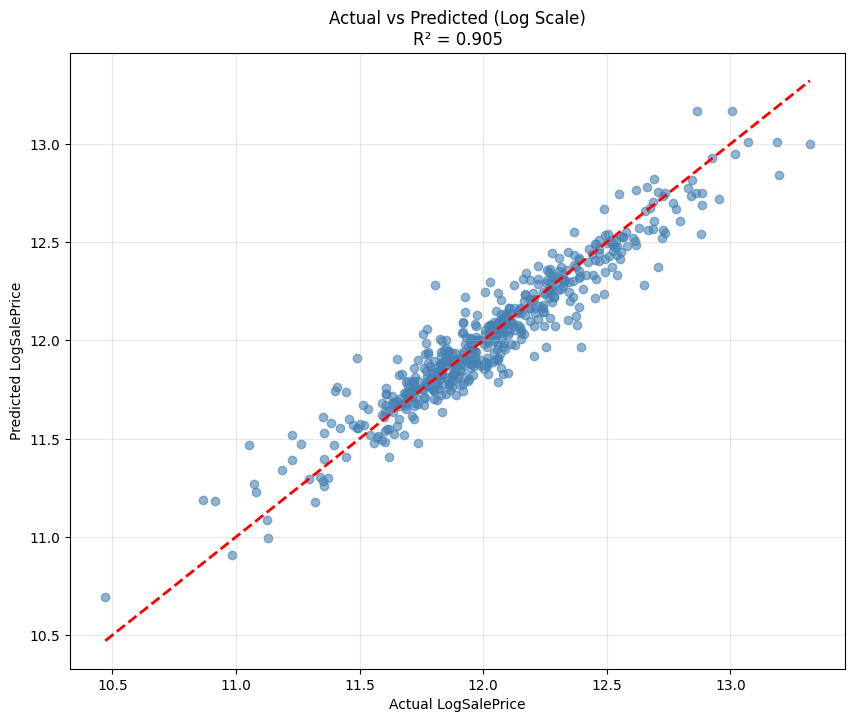

In [ ]:
# Actual vs Predicted (Log Scale)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual LogSalePrice')
plt.ylabel('Predicted LogSalePrice')
plt.title(f'Actual vs Predicted (Log Scale)\nR² = {test_r2:.3f}')
plt.grid(True, alpha=0.3)


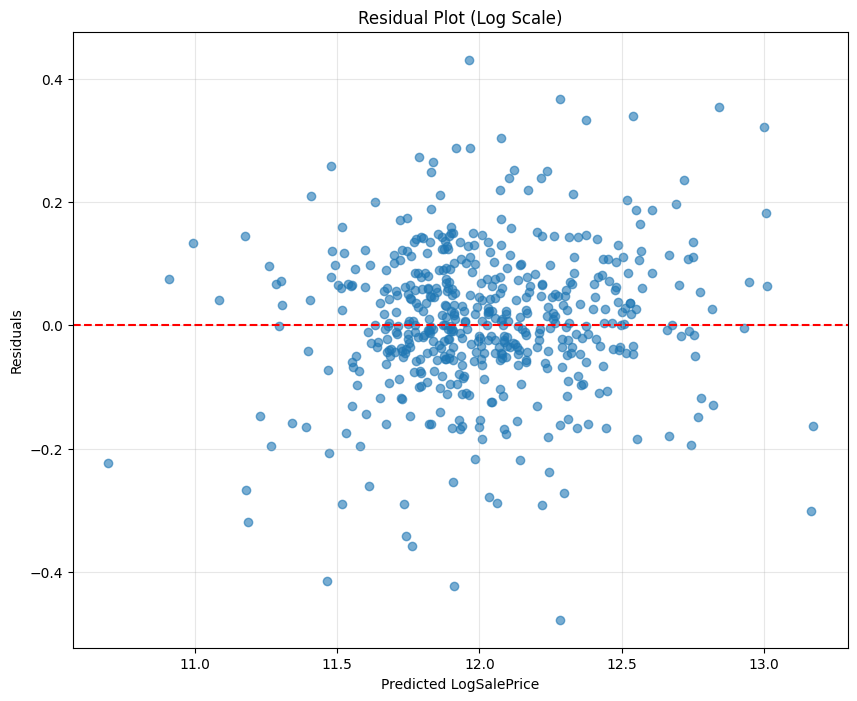

In [ ]:
# Residuals (Log Scale)
plt.figure(figsize=(10, 8))
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted LogSalePrice')
plt.ylabel('Residuals')
plt.title('Residual Plot (Log Scale)')
plt.grid(True, alpha=0.3)

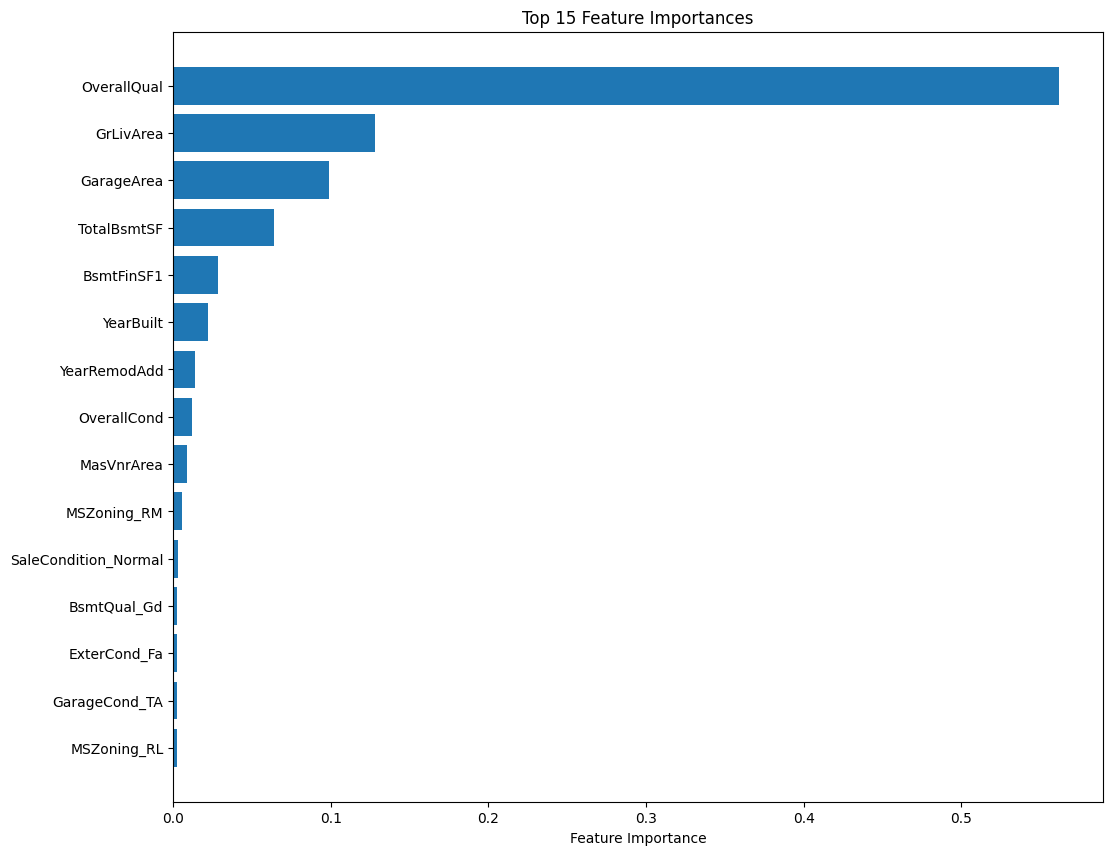

In [42]:
# Feature Importance (Top 15)
plt.figure(figsize=(12, 10))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), [f[:25] + '...' if len(f) > 25 else f for f in top_15['feature']])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()

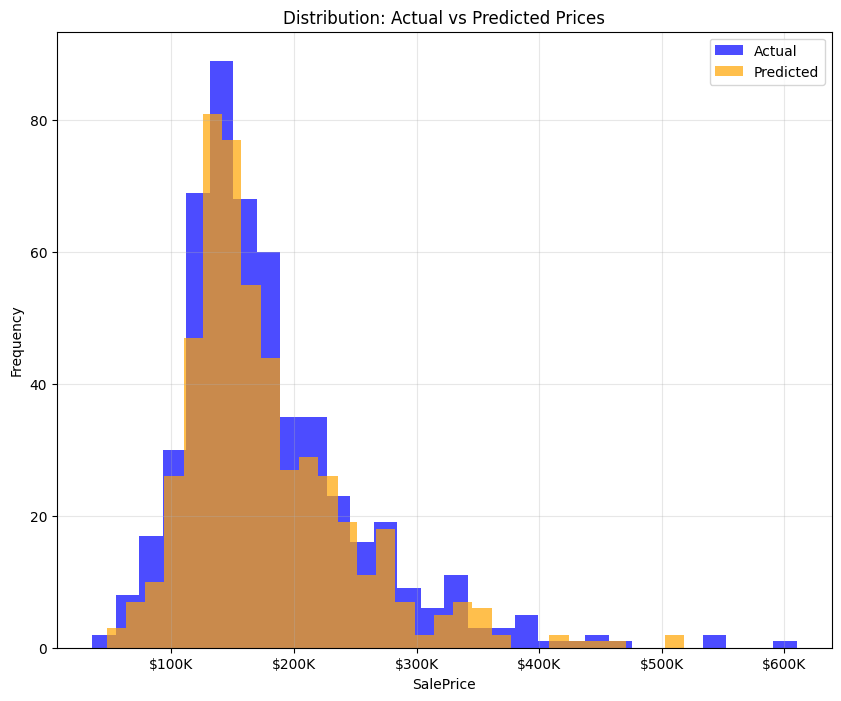

In [ ]:
# Prediction distribution (Original Scale)
plt.figure(figsize=(10, 8))
plt.hist(y_test_original, alpha=0.7, label='Actual', bins=30, color='blue')
plt.hist(y_test_pred_original, alpha=0.7, label='Predicted', bins=30, color='orange')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Distribution: Actual vs Predicted Prices')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.legend()
plt.grid(True, alpha=0.3)